In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime as dt
import math
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [171]:
ais_dataset = pd.read_csv('./datasets/ais_dataset.csv')
port_call_dataset = pd.read_csv('./datasets/port_call_dataset.csv')
distance_dataset = pd.read_csv('./datasets/distance_dataset.csv')




print(len(ais_dataset['imo'].unique()))
print(len(port_call_dataset['imo'].unique()))
print(ais_dataset.info())
print(port_call_dataset.info())
print(distance_dataset.info())
# no terminal, maneuvering , berth
# suggests that only anchored and transit
# we can simply find if anchored or not

2543
4166
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251769 entries, 0 to 251768
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   imo                    251769 non-null  int64  
 1   mmsi                   251769 non-null  int64  
 2   vessel_name            251769 non-null  object 
 3   date_of_build          251769 non-null  object 
 4   vessel_type            251769 non-null  object 
 5   group                  251769 non-null  object 
 6   timestamp              251769 non-null  object 
 7   lon                    251769 non-null  float64
 8   lat                    251769 non-null  float64
 9   nav_stat               251769 non-null  int64  
 10  speed                  249752 non-null  float64
 11  course                 251769 non-null  int64  
 12  heading                250464 non-null  float64
 13  fuel_category          251769 non-null  int64  
 14  main_engine_fuel_type  251

### Dropping Columns
---

##### AIS

In [172]:
# dropping missing values
ais_dataset.drop(columns=['berth' , 'terminal' , 'maneuvering_zone'] , inplace=True)
# ais_dataset.dropna(inplace=True) # 《 5% missing data

In [173]:
# From background research cum provided information
# ABL AEL !== 0
# drop meta data:
# port_name , mmsi (cannot be used since other datasets only have imo) , date_of_build
useless_columns = ['port_name' , 'mmsi' , 'date_of_build']
ais_dataset.drop(columns=useless_columns , inplace=True)

In [174]:
abl_ael_not_zero_condition = (ais_dataset['abl'] > 0) & (ais_dataset['ael'] > 0)
ais_dataset = ais_dataset[abl_ael_not_zero_condition]

In [175]:
ais_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248013 entries, 0 to 251768
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   imo                    248013 non-null  int64  
 1   vessel_name            248013 non-null  object 
 2   vessel_type            248013 non-null  object 
 3   group                  248013 non-null  object 
 4   timestamp              248013 non-null  object 
 5   lon                    248013 non-null  float64
 6   lat                    248013 non-null  float64
 7   nav_stat               248013 non-null  int64  
 8   speed                  246213 non-null  float64
 9   course                 248013 non-null  int64  
 10  heading                246742 non-null  float64
 11  fuel_category          248013 non-null  int64  
 12  main_engine_fuel_type  248013 non-null  object 
 13  aux_engine_fuel_type   248013 non-null  object 
 14  engine_type            247590 non-null  o

### Imputing

In [176]:
# When looking through the speed we notice each imo has a null speed
# This suggests that each ship is anchored-travels to sg-travels further/stays in sg
# Speed null values can be imputed as '0'
ais_dataset['speed'].fillna(0 , inplace=True)

In [177]:
# We can also drop speeds that are greather than 30
less_than_30_condition = ais_dataset['speed'] < 30
ais_dataset = ais_dataset[less_than_30_condition]

In [178]:
ais_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248013 entries, 0 to 251768
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   imo                    248013 non-null  int64  
 1   vessel_name            248013 non-null  object 
 2   vessel_type            248013 non-null  object 
 3   group                  248013 non-null  object 
 4   timestamp              248013 non-null  object 
 5   lon                    248013 non-null  float64
 6   lat                    248013 non-null  float64
 7   nav_stat               248013 non-null  int64  
 8   speed                  248013 non-null  float64
 9   course                 248013 non-null  int64  
 10  heading                246742 non-null  float64
 11  fuel_category          248013 non-null  int64  
 12  main_engine_fuel_type  248013 non-null  object 
 13  aux_engine_fuel_type   248013 non-null  object 
 14  engine_type            247590 non-null  o

### Feature Engineering

port call

In [179]:
# creating time col (duration spent during an event)
# duration travelled = current - prev earliest time
# duration in port = current latest - current earliest
def get_time_difference_in_seconds_from_utc(s1 , s2):
  try: 
    current_time_timestamp = dt.strptime(s1, '%Y-%m-%dT%H:%M:%S.%f%z').timestamp()
    prev_time_timestamp = dt.strptime(s2, '%Y-%m-%dT%H:%M:%S.%f%z').timestamp()
    duration_timestamp_seconds = abs(current_time_timestamp - prev_time_timestamp)
    return duration_timestamp_seconds
  except:
    # For when value is null
    return np.nan

def get_duration(col1 , col2):
  def calculate(rows):
    s1 = rows[col1]
    s2 = rows[col2]
    return round(get_time_difference_in_seconds_from_utc(s1 , s2) / 3600 , 5) # rounding to 5 dp
  
  return calculate


prev_anchor = ['prev_country_earliest_visit_time_utc' , 'prev_country_latest_visit_time_utc']
prev_to_sg_transit = ['prev_country_latest_visit_time_utc' , 'current_earliest_visit_time_utc']
sg_anchor = ['current_latest_visit_time_utc' , 'current_earliest_visit_time_utc']
sg_to_next_transit = ['current_latest_visit_time_utc' , 'next_country_earliest_visit_time_utc']
next_anchor = ['next_country_earliest_visit_time_utc' , 'next_country_latest_visit_time_utc']

port_call_dataset['Prev Anchor'] = port_call_dataset.loc[: , prev_anchor].apply(get_duration(*prev_anchor) , axis=1)
port_call_dataset['Prev to SG Transit'] = port_call_dataset.loc[: , prev_to_sg_transit].apply(get_duration(*prev_to_sg_transit), axis=1)
port_call_dataset['SG Anchor'] = port_call_dataset.loc[: , sg_anchor].apply(get_duration(*sg_anchor), axis=1)
port_call_dataset['SG to Next Transit'] = port_call_dataset.loc[: , sg_to_next_transit].apply(get_duration(*sg_to_next_transit) , axis=1)
port_call_dataset['Next Anchor'] = port_call_dataset.loc[: , next_anchor].apply(get_duration(*next_anchor) , axis=1)

AIS dataset

In [180]:
# Handling state (transit or anchored)
def get_state(row):
  TRANSIT_NAV_STAT = [0 , 3 , 4 , 8 , 11 , 12]
  if row['speed'] > 1 or row['nav_stat'] in TRANSIT_NAV_STAT:
    return 'Transit'
  elif row['speed'] < 1 and row['nav_stat'] == 0:
    return 'Anchored'

In [181]:
ais_dataset['state'] = ais_dataset.apply(get_state , axis=1)

In [182]:
ais_dataset['state']

0         Transit
1         Transit
2         Transit
3         Transit
4         Transit
           ...   
251764    Transit
251765    Transit
251766    Transit
251767    Transit
251768    Transit
Name: state, Length: 248013, dtype: object

In [183]:
# Adding the admission tier


### Calculating Before Emissions

In [184]:
# Calculating ef
ais_dataset['ef_me'] = ais_dataset['sfc_me'] * 0.867 * 3.667
ais_dataset['ef_ae'] = ais_dataset['sfc_ae'] * 0.867 * 3.667
ais_dataset['ef_ab'] = ais_dataset['sfc_ab'] * 0.867 * 3.667


In [185]:
# Calculating Max Speed
result = pd.merge(distance_dataset , ais_dataset[['imo' , 'vref']] , how='inner' , on='imo')
result.drop_duplicates()

,snapshot_date_utc,imo,distance_nm,duration_minutes,avg_speed_kt,min_speed_kt,max_speed_kt,vref
0,2024-07-24,1013327,29.84,1184.43,2.19,0.03,7.83,11.5
2,2024-07-20,1015820,65.42,1312.65,3.18,0.02,11.91,9.0
279,2024-07-08,1043011,79.17,1112.48,4.45,0.03,14.48,13.5
523,2024-07-03,1043011,294.39,1438.94,11.94,9.52,12.91,13.5
767,2024-07-02,1043011,272.40,1428.30,11.02,8.49,11.92,13.5
...,...,...,...,...,...,...,...,...
390899,2024-07-15,9958597,58.63,1037.51,3.73,0.05,15.57,13.8
391198,2024-07-03,9958640,221.23,853.42,14.80,11.18,17.03,19.5
391199,2024-07-02,9967524,145.21,1280.96,5.73,0.02,17.82,21.0
391203,2024-07-19,9968906,105.47,568.87,11.25,0.05,14.27,19.0


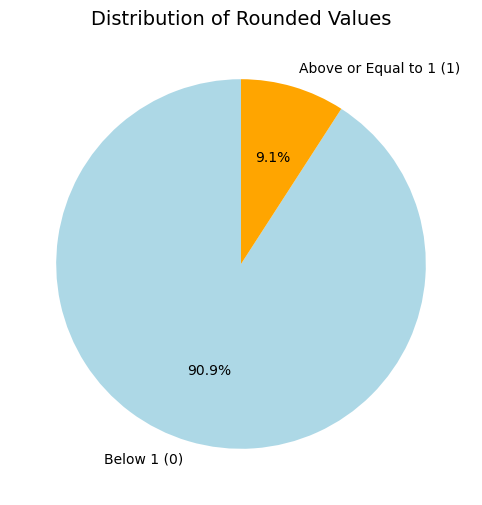

In [186]:
result["ratio"] = result["max_speed_kt"] / result["vref"]
result["rounded"] = result["ratio"].apply(lambda x: 0 if x < 1 else 1)

# Count the number of 0s and 1s
counts = result["rounded"].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 6))
counts.plot.pie(
    labels=["Below 1 (0)", "Above or Equal to 1 (1)"],
    autopct="%1.1f%%",
    startangle=90,
    colors=["lightblue", "orange"]
)

# Add a title
plt.title("Distribution of Rounded Values", fontsize=14)
plt.ylabel("")  # Hide the y-axis label
plt.show()

In [187]:
print(np.average(port_call_dataset['SG Anchor']))
print(np.average(port_call_dataset['Prev Anchor']))
print(np.average(port_call_dataset['Next Anchor'].notnull()))

3.9299050600096015
1.5400323979836774
0.971435429668747


In [188]:
print(port_call_dataset['current_earliest_visit_time_utc'].unique)
print(ais_dataset.columns)

<bound method Series.unique of 0       2024-07-24T12:03:26.000+0000
1       2024-07-20T08:10:02.000+0000
2       2024-07-13T22:51:23.000+0000
3       2024-07-08T11:10:58.000+0000
4       2024-07-02T19:50:23.000+0000
                    ...             
4161    2024-07-14T02:25:32.000+0000
4162    2024-07-17T17:50:02.000+0000
4163    2024-07-06T06:40:02.000+0000
4164    2024-07-02T15:28:48.000+0000
4165    2024-07-16T01:31:16.000+0000
Name: current_earliest_visit_time_utc, Length: 4166, dtype: object>
Index(['imo', 'vessel_name', 'vessel_type', 'group', 'timestamp', 'lon', 'lat',
       'nav_stat', 'speed', 'course', 'heading', 'fuel_category',
       'main_engine_fuel_type', 'aux_engine_fuel_type', 'engine_type',
       'anchorage', 'p', 'vref', 'sfc_me', 'sfc_ae', 'sfc_ab', 'ael', 'abl',
       'distance', 'state', 'ef_me', 'ef_ae', 'ef_ab'],
      dtype='object')


In [189]:
avgtime = pd.merge(port_call_dataset, ais_dataset[['imo', 'vessel_type']], how='inner', on='imo')
# Check the columns of the merged DataFrame to ensure 'vessel_type' is present
print(avgtime.columns)

# Now group by 'vessel_type' and calculate the mean of 'Sg Anchor'
avg_time_per_vessel_type = avgtime.groupby('vessel_type')['SG Anchor'].mean()
avg_speed_per_vessel_type = avgtime.groupby('vessel_type')['Prev to SG Transit'].mean()# Print the result
print(avg_time_per_vessel_type.nlargest(10))
print(avg_speed_per_vessel_type.nlargest(10))

Index(['current_snapshot_date_utc', 'imo', 'current_port_name',
       'current_port_country_name', 'current_earliest_visit_time_utc',
       'current_latest_visit_time_utc', 'current_zone_polygon_name',
       'current_zone_type', 'next_port_name', 'next_country_name',
       'next_country_earliest_visit_time_utc',
       'next_country_latest_visit_time_utc', 'next_zone_polygon_name',
       'next_snapshot_date', 'next_zone_type', 'prev_port_name',
       'prev_country_name', 'prev_country_earliest_visit_time_utc',
       'prev_country_latest_visit_time_utc', 'prev_zone_polygon_name',
       'prev_snapshot_date', 'prev_zone_type', 'Prev Anchor',
       'Prev to SG Transit', 'SG Anchor', 'SG to Next Transit', 'Next Anchor',
       'vessel_type'],
      dtype='object')
vessel_type
Deck Cargo Ship              22.287801
Shuttle Tanker               17.537780
Livestock Carrier            17.138988
Heavy Load Carrier           16.533120
LNG Tanker                   16.162102
Crude Oil Tank